## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools

## Data

In [2]:
# --- 데이터 로드 ---
df_origin = pd.read_excel('final_features_for_dnn.xlsx', index_col='doc_id')
df_perp = pd.read_csv("Llama_perp.csv")
df_full = pd.concat([df_origin, df_perp], axis = 1)

In [3]:
lda_features = [col for col in df_full.columns if '-' in col]
stylometric_features = ['prp_ratio', 'lexical_density', 'difficult_words_ratio', 'unique_word_count', "perp"]
all_feature_groups = {'LDA': lda_features, **{feat: [feat] for feat in stylometric_features}}
all_feature_list = lda_features + stylometric_features

## For DNN

In [4]:
# --- DNN 모델 정의 ---
class DNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DNN, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.4),
            nn.Linear(256, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.4),
            nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(0.3),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, num_classes)  ## 분류 문제에 따라 다른 수: 5/1
        ).to("cuda:0")
    def forward(self, x):
        return self.layer_stack(x)  ## network

# --- 모델 훈련 및 평가 함수 ---
def train_and_evaluate(X, y, num_classes):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()   ## 피쳐 정규화
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to("cuda:0")
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    model = DNN(input_dim=X.shape[1], num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

    ## 30 에폭 + GPU 배치 훈련
    num_epochs = 30 
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to("cuda:0")
            labels = labels.to("cuda:0")
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = accuracy_score(y_test, predicted.cpu().numpy())

    print(f"current model accurary: {accuracy:.4f}")
    return (predicted.cpu().numpy(), y_test) ## 정확도 반환... 라벨도 반환 해줘잉

In [5]:
torch.manual_seed(42)

# --- 다중 분류 실험 ---
le_multi = LabelEncoder()
y_multi_class = le_multi.fit_transform(df_full["llm_name"])
num_classes_multi = len(np.unique(y_multi_class))
multi_class_results = {}

X = df_full[all_feature_list].values
multi_class_results['All Features (Baseline)'] = train_and_evaluate(X, y_multi_class, num_classes_multi)

# --- 퍼플렉시티 제거 ---
features_to_use = [f for f in all_feature_list if f not in "perp"]
X = df_full[features_to_use].values
multi_class_results[f"Exclude perp"] = train_and_evaluate(X, y_multi_class, num_classes_multi)

# --- 퍼플렉시티만 포함 ---
X = df_full[["perp"]].values
multi_class_results[f"Only perp"] = train_and_evaluate(X, y_multi_class, num_classes_multi)

current model accurary: 0.8598
current model accurary: 0.8160
current model accurary: 0.4732


In [6]:
# --- 이진 분류 실험 ---
df_binary = df_full.copy()
df_binary['llm_name'] = df_binary['llm_name'].apply(lambda x: 'human' if x == 'human' else 'llm')
le_binary = LabelEncoder()
y_binary_class = le_binary.fit_transform(df_binary['llm_name'])
num_classes_binary = len(np.unique(y_binary_class))
binary_class_results = {}

X = df_binary[all_feature_list].values
binary_class_results['All Features (Baseline)'] = train_and_evaluate(X, y_binary_class, num_classes_binary)

# --- 퍼플렉시티 제거 ---
features_to_use = [f for f in all_feature_list if f not in "perp"]
X = df_binary[features_to_use].values
binary_class_results[f"Exclude perp"] = train_and_evaluate(X, y_binary_class, num_classes_multi)

# --- 퍼플렉시티만 포함 ---
X = df_binary[["perp"]].values
binary_class_results[f"Only perp"] = train_and_evaluate(X, y_binary_class, num_classes_multi)

current model accurary: 0.9778
current model accurary: 0.9599
current model accurary: 0.8864


## 결과 종합

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
labels = ['deepseek', 'claude', 'gemini', 'gpt', 'human']
binary_labels = ["human", "llm"]

In [9]:
def heatmap_vis(y_true, y_pred, labels, type: str):
    plt.figure(figsize = (10, 8))
    ax = sns.heatmap(
        confusion_matrix(y_true, y_pred, labels = labels),
        annot = True,
        annot_kws = {"size": 20},
        fmt = "d",
        cmap = "Blues",
        xticklabels = labels,
        yticklabels = labels
    )

    ax.tick_params(axis = "x", top = True, bottom = False, labeltop = True, labelbottom = False)
    ax.set_title("Predicted Label", fontsize = 24, pad = 10)
    ax.set_ylabel("Actual Label", fontsize = 24)

    cb = ax.collections[0].colorbar
    cb.ax.tick_params(labelsize = 14)

    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20, rotation = 0)
    plt.savefig(f"{type}_confusion_matrix.png", dpi = 300, bbox_inches = "tight")

def multi_get_report(y_true, y_pred):
    report_dict = classification_report(y_true, y_pred, labels = labels, output_dict = True)

    # pandas DataFrame으로 변환하여 출력 형식 지정
    df_report = pd.DataFrame(report_dict).transpose()
    print(df_report.to_string(float_format=lambda x: f"{x:.4f}"))

    return df_report

def binary_get_report(y_true, y_pred):
    # 이진 분류 리포트를 딕셔너리로 받기
    report_binary_dict = classification_report(y_true, y_pred, target_names=binary_labels, output_dict=True)

    # DataFrame으로 변환하여 출력 형식 지정
    df_binary_report = pd.DataFrame(report_binary_dict).transpose()
    print(df_binary_report.to_string(float_format=lambda x: f"{x:.4f}"))

    return df_binary_report

`-` 퍼플렉시티를 추가한 경우

In [10]:
print("="*15, "Multi-class Metrics", "="*15)
yyhat, yy = multi_class_results["All Features (Baseline)"]
pred, actual = le_multi.inverse_transform(yyhat), le_multi.inverse_transform(yy)

all_features_report_multi = multi_get_report(actual, pred)

=============== Multi-class Metrics ===============
              precision  recall  f1-score   support
deepseek         0.8151  0.7717    0.7928  600.0000
claude           0.7929  0.8167    0.8046  600.0000
gemini           0.8620  0.8950    0.8782  600.0000
gpt              0.8754  0.8667    0.8710  600.0000
human            0.9592  0.9541    0.9567  567.0000
accuracy         0.8598  0.8598    0.8598    0.8598
macro avg        0.8609  0.8608    0.8607 2967.0000
weighted avg     0.8598  0.8598    0.8596 2967.0000


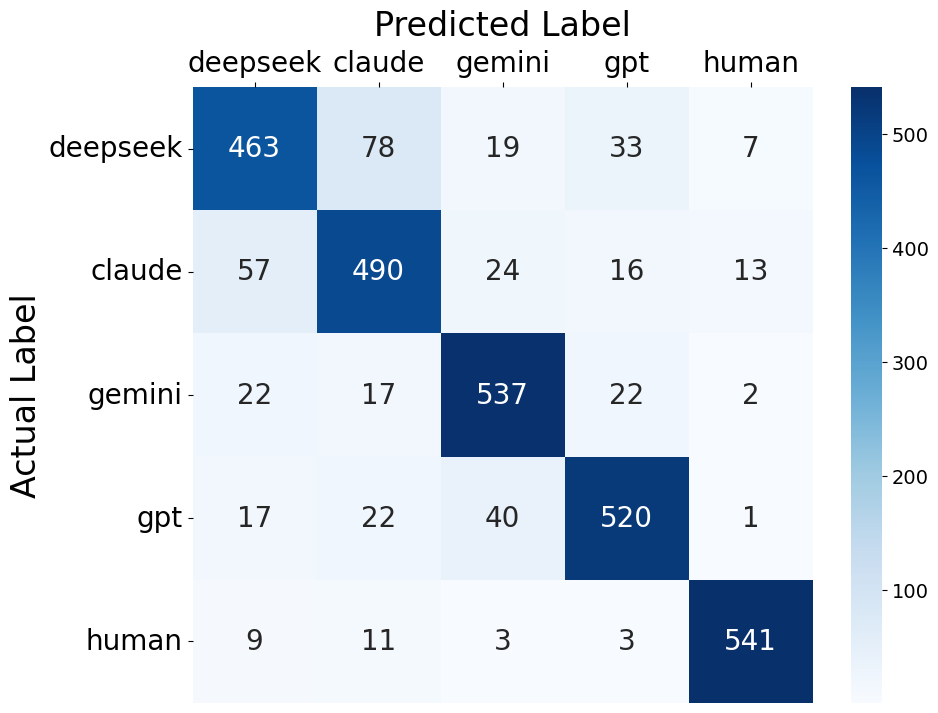

In [11]:
heatmap_vis(actual, pred, labels, "with_perp")

In [12]:
print("\n" + "="*15, "Binary Metrics", "="*15)
yyhat, yy = binary_class_results["All Features (Baseline)"]
pred, actual = le_binary.inverse_transform(yyhat), le_binary.inverse_transform(yy)

all_features_report_binary = binary_get_report(actual, pred)


=============== Binary Metrics ===============
              precision  recall  f1-score   support
human            0.9753  0.9065    0.9397  567.0000
llm              0.9783  0.9946    0.9864 2400.0000
accuracy         0.9778  0.9778    0.9778    0.9778
macro avg        0.9768  0.9506    0.9630 2967.0000
weighted avg     0.9777  0.9778    0.9774 2967.0000


`-` 기존 모델

In [13]:
print("="*15, "Multi-class Metrics", "="*15)
yyhat, yy = multi_class_results["Exclude perp"]
pred, actual = le_multi.inverse_transform(yyhat), le_multi.inverse_transform(yy)

original_report_multi = multi_get_report(actual, pred)

=============== Multi-class Metrics ===============
              precision  recall  f1-score   support
deepseek         0.8094  0.7433    0.7750  600.0000
claude           0.7433  0.7817    0.7620  600.0000
gemini           0.7578  0.8550    0.8034  600.0000
gpt              0.8652  0.8133    0.8385  600.0000
human            0.9283  0.8907    0.9091  567.0000
accuracy         0.8160  0.8160    0.8160    0.8160
macro avg        0.8208  0.8168    0.8176 2967.0000
weighted avg     0.8196  0.8160    0.8166 2967.0000


In [14]:
print("\n" + "="*15, "Binary Metrics", "="*15)
yyhat, yy = binary_class_results["Exclude perp"]
pred, actual = le_binary.inverse_transform(yyhat), le_binary.inverse_transform(yy)

original_report_binary = binary_get_report(actual, pred)


=============== Binary Metrics ===============
              precision  recall  f1-score   support
human            0.9375  0.8466    0.8897  567.0000
llm              0.9646  0.9867    0.9755 2400.0000
accuracy         0.9599  0.9599    0.9599    0.9599
macro avg        0.9510  0.9166    0.9326 2967.0000
weighted avg     0.9594  0.9599    0.9591 2967.0000


In [19]:
original_report_binary

,precision,recall,f1-score,support
human,0.937500,0.846561,0.889713,567.000000
llm,0.964562,0.986667,0.975489,2400.000000
accuracy,0.959892,0.959892,0.959892,0.959892
macro avg,0.951031,0.916614,0.932601,2967.000000
weighted avg,0.959390,0.959892,0.959097,2967.000000


In [22]:
origin_acc = original_report_binary.iloc[2, 0]
all_acc = all_features_report_binary.iloc[2, 0]

In [26]:
1 - (1 - all_acc)/(1 - origin_acc)

np.float64(0.4453781512605043)

In [ ]:
origin_acc_multi = original_report_multi.iloc[5, 0]
all_acc_multi = all_features_report_multi.iloc[5, 0]

In [30]:
1 - (1 - all_acc_multi)/(1 - origin_acc_multi)

np.float64(0.23809523809523814)

`-` 퍼플렉시티만 포함한 모델

In [62]:
print("="*15, "Multi-class Metrics", "="*15)
yyhat, yy = multi_class_results["Only perp"]
pred, actual = le_multi.inverse_transform(yyhat), le_multi.inverse_transform(yy)

only_perp_report_multi = multi_get_report(actual, pred)

=============== Multi-class Metrics ===============
              precision  recall  f1-score   support
deepseek         0.3151  0.1250    0.1790  600.0000
claude           0.3902  0.5867    0.4687  600.0000
gemini           0.5971  0.6250    0.6107  600.0000
gpt              0.3381  0.4300    0.3786  600.0000
human            0.7890  0.6067    0.6859  567.0000
accuracy         0.4732  0.4732    0.4732    0.4732
macro avg        0.4859  0.4747    0.4646 2967.0000
weighted avg     0.4826  0.4732    0.4621 2967.0000


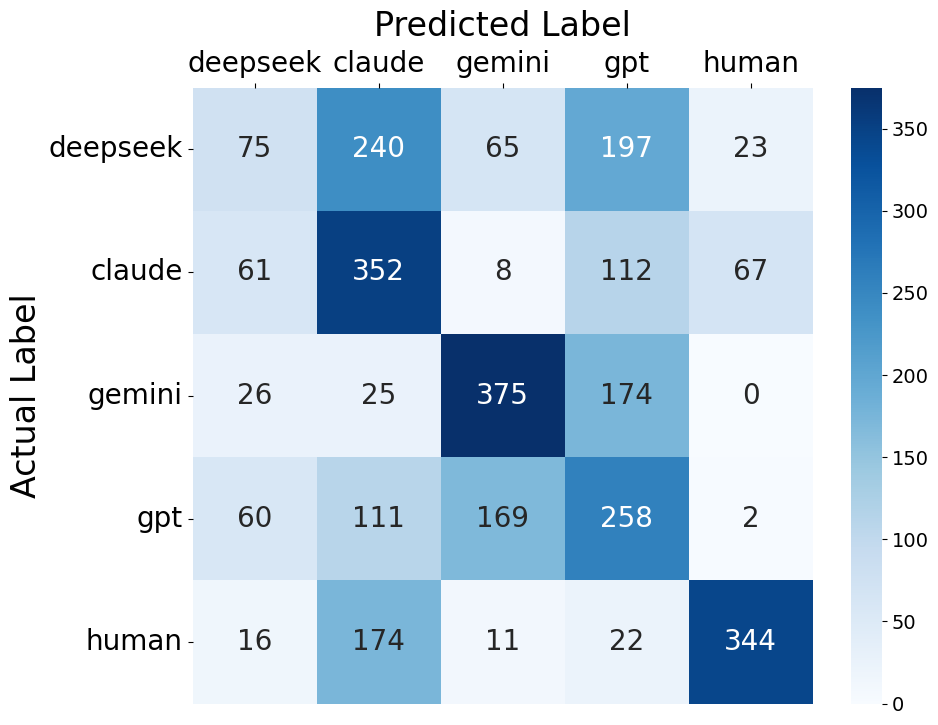

In [63]:
heatmap_vis(actual, pred, labels, "only_perp")

In [83]:
print("\n" + "="*15, "Binary Metrics", "="*15)
yyhat, yy = binary_class_results["Only perp"]
pred, actual = le_binary.inverse_transform(yyhat), le_binary.inverse_transform(yy)

all_features_report_binary = binary_get_report(actual, pred)


=============== Binary Metrics ===============
              precision  recall  f1-score   support
human            0.7489  0.6102    0.6725  567.0000
llm              0.9118  0.9517    0.9313 2400.0000
accuracy         0.8864  0.8864    0.8864    0.8864
macro avg        0.8303  0.7809    0.8019 2967.0000
weighted avg     0.8807  0.8864    0.8818 2967.0000


In [89]:
(((actual == "llm")[pred == "llm"]).mean() + ((actual == "human")[pred == "human"]).mean())/2

np.float64(0.8303470980117686)

In [ ]:
0.401